# Homework Assignment 3

Using the [Seattle Library Collection Inventory Dataset](https://www.kaggle.com/city-of-seattle/seattle-library-collection-inventory#library-collection-inventory.csv) and Vaex please, answer the following questions:

Important Note: **You can use a reltaviely small subset of the big dataset.**

**Question 1:** Using Vaex, write a function that returns the most popular book in each subject. Use it to find the most popular book in
    the _Mystery Fiction_ subject (15pt)

In [1]:
!pip install vaex

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Use the full path to your file in Google Drive
file_path = '/content/drive/MyDrive/PhD/BGU/BigData/HW3/library-collection-inventory.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import vaex

# Load the dataset into Vaex
df = vaex.open(file_path)

In [51]:
# Optional: Export a smaller subset (if needed)
df_subset = df.head(1_000)

In [52]:
print(df_subset.head())

  #    BibNum  Title                                                Author                     ISBN                                                 PublicationYear    Publisher                          Subjects                                             ItemType    ItemCollection    FloatingItem    ItemLocation    ReportDate             ItemCount
  0   3011076  "A tale of two friends / adapted by Ellie O'Ryan...  O'Ryan, Ellie              '1481425730, 1481425749, 9781481425735, 97814814...  2014.              Simon Spotlight,                   'Musicians Fiction, Bullfighters Fiction, Best f...  jcbk        ncrdr             Floating        qna             2017-09-01 00:00:00            1
  1   2248846  'Naruto. Vol. 1, Uzumaki Naruto / story and art ...  Kishimoto, Masashi, 1974-  1569319006                                           2003, c1999.       Viz,                               'Ninja Japan Comic books strips etc, Comic books...  acbk        nycomic           NA             

In [54]:
# Filter to only include rows where 'ItemType' is 'Book'
df_books = df_subset[df_subset['ItemType'] == 'acbk']

df_books_fiction = df_books[df_books['Subjects'].str.contains('Fiction')]

# Group by 'BibNum' and count occurrences of each book
df_grouped = df_books_fiction.groupby('BibNum', agg={'popularity_count': vaex.agg.count()})

# Sort by popularity count to find the most popular books
df_sorted = df_grouped.sort(by='popularity_count', ascending=False)

# Display the result
print(df_sorted.head())

  #    BibNum    popularity_count
  0   3061953                  26
  1   3244926                  26
  2   3157000                  26
  3   3208214                  25
  4   3168629                  25
  5   3224239                  25
  6   3180774                  25
  7   3265070                  25
  8   3182488                  25
  9   3219278                  25


**Question 2**: Using Vaex, find the top-10 fiction subjects (5pt), and use Seaborn to visualize the number of items over time for each subject (15pt)
    

In [56]:
import vaex

# Filter rows where ItemType is 'Book' and subject contains 'Fiction'
df_books_fiction = df_subset[df_subset['ItemType'] == 'acbk']
df_books_fiction = df_books_fiction[df_books_fiction['Subjects'].str.contains('Fiction')]

# Group by subjects and count the number of items
df_grouped = df_books_fiction.groupby('Subjects', agg={'count_items': vaex.agg.count()})

# Sort and display the top 10 subjects
df_top_10_subjects = df_grouped.sort(by='count_items', ascending=False).head(10)
print(df_top_10_subjects)


  #  Subjects                                               count_items
  0  Man woman relationships Fiction, Love stories                  244
  1  Magic Fiction, Fantasy fiction                                  95
  2  Man woman relationships Fiction                                 84
  3  Murder Investigation Fiction, Mystery fiction                   83
  4  Space warfare Fiction, Science fiction                          77
  5  'Imaginary wars and battles Fiction, Fantasy fic...             68
  6  Vampires Fiction, Paranormal romance stories                    66
  7  Life on other planets Fiction, Science fiction                  52
  8  'Spenser Fictitious character Fiction, Private i...             51
  9  Sisters Fiction, Domestic fiction                               48


#    Subjects                                             PublicationYear    book_count
0    World War 1939 1945 Fiction                          1985               2
1    Life on other planets Fiction, Science fiction                          10
2    'Imaginary wars and battles Fiction, Fantasy fic...  2012               2
3    Life on other planets Fiction, Science fiction       2014               4
4    'United States Social life and customs 20th cent...  2007               7
...  ...                                                  ...                ...
133  Human alien encounters Fiction, Science fiction      2016               9
134  World War 1939 1945 Fiction                          2001               1
135  Space warfare Fiction, Science fiction               2005               1
136  Magic Fiction, Fantasy fiction                       2006               1
137  'United States Social life and customs 20th cent...  1991               2


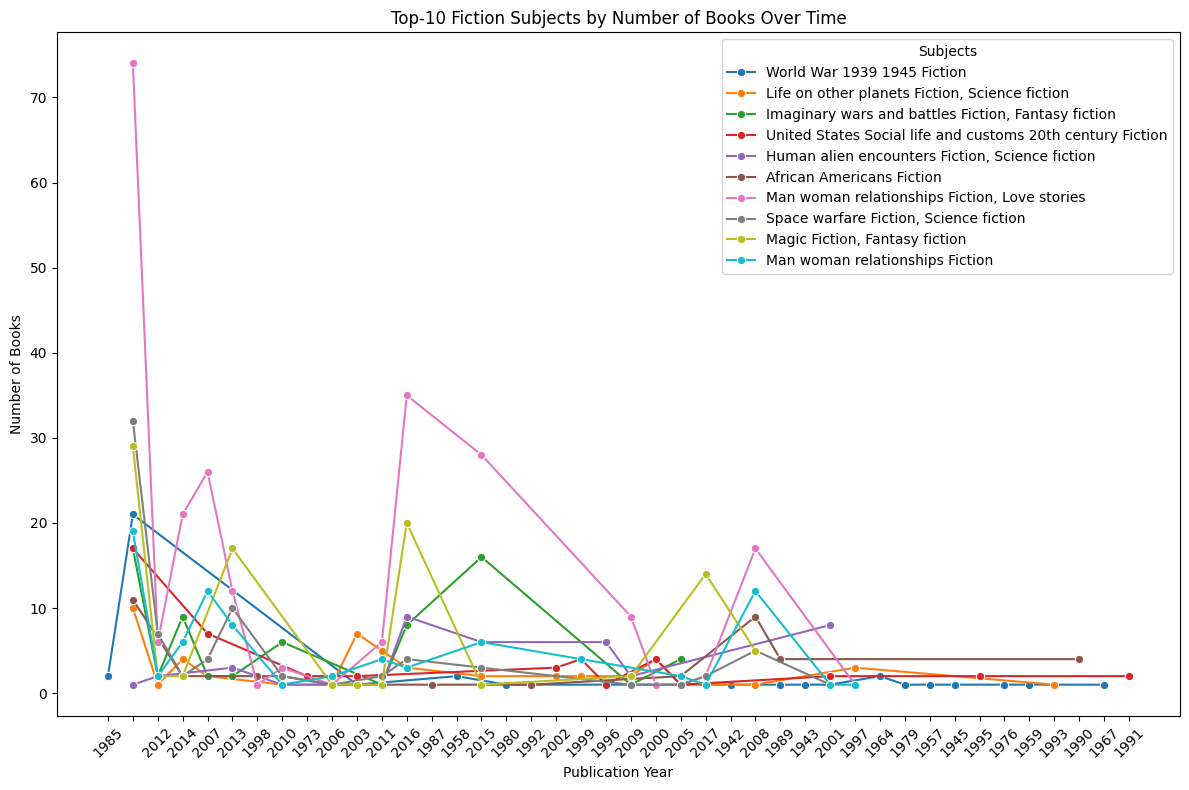

In [94]:
import vaex
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for books and only fiction subjects
df_books_fiction = df_subset[df_subset['ItemType'] == 'acbk']
df_books_fiction = df_books_fiction[df_books_fiction['Subjects'].str.contains('Fiction')]

# Clean the 'PublicationYear' column to extract valid year format (4-digit year)
df_books_fiction['PublicationYear'] = df_books_fiction['PublicationYear'].str.replace(r'[^\d{4}].*', r'\1', regex=True)

# Group by 'Subjects' and 'PublicationYear', then count the number of books in each group
df_grouped = df_books_fiction.groupby(['Subjects', 'PublicationYear'], agg={'book_count': vaex.agg.count()})

# Filter top-10 fiction subjects
top_10_subjects = df_grouped['Subjects'].value_counts().head(10).index

# Filter dataset for top-10 subjects
df_top_10 = df_grouped[df_grouped['Subjects'].isin(top_10_subjects)]

print(df_top_10)

# Convert the Vaex DataFrame to a pandas DataFrame
df_top_10 = df_top_10.to_pandas_df()

# Plot the number of books over time for each subject
plt.figure(figsize=(12, 8))
sns.lineplot(data=df_top_10, x='PublicationYear', y='book_count', hue='Subjects', marker='o')
plt.title('Top-10 Fiction Subjects by Number of Books Over Time')
plt.xlabel('Publication Year')
plt.ylabel('Number of Books')
plt.legend(title='Subjects')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Question 3:** Using Vaex, write a function that gets as input a subject name. The function returns the top-20 most _popular_ authors for the input subject (15pt).



In [97]:
import vaex

# Define the function to get the top 20 authors for a given subject
def top_20_authors_by_subject(df, subject_name):
    # Filter for the rows matching the subject and get the counts per author
    df_filtered = df[df['Subjects'].str.contains(subject_name)]

    # Group by 'Author' and aggregate by the sum of 'ItemCount'
    df_grouped = df_filtered.groupby('Author', agg={'popularity': vaex.agg.sum('ItemCount')})

    # Sort by popularity in descending order and get the top 20 authors
    df_sorted = df_grouped.sort(by='popularity', ascending=False)
    return df_sorted.head(20)

# Example usage
top_20_mystery_fiction_authors = top_20_authors_by_subject(df_subset, 'Fiction')
print(top_20_mystery_fiction_authors)


#    Author                   popularity
0                             84698
1    Willems, Mo              1825
2    Patterson, James, 1947-  1704
3    Meadows, Daisy           1294
4    Osborne, Mary Pope       974
...  ...                      ...
15   Penny, Louise            434
16   Cronin, Doreen           432
17   Kinney, Jeff             427
18   Baldacci, David          420
19   Gutman, Dan              416


Using the [The Blog Authorship Corpus](https://www.kaggle.com/rtatman/blog-authorship-corpus.htm) and Vaex, please answer the following questions:

**Question 4:** Calculate the average and median age of bloggers in each topic by gender(5pt).
Calculate the average and median age of bloggers according to their sign (5pt).
Visualize the age distributions  of bloggers according to their  topic and gender using Seaborn and PlotlyExpress(15pt)

**Question 5:** Using the  [SJR Journal Ranking of 2018](https://www.scimagojr.com/journalrank.php) dataset and Seaborn, visualize
    the H-index distributions according to the SJR Best Quartile (15pt). Using a grid, visualize the _Cites / Doc. (2years)_ histograms values of each publisher (15pt).

**Note: You can use only the top publishers **
    


   Rank     Sourceid                                       Title     Type  \
0     1        28773          Ca-A Cancer Journal for Clinicians  journal   
1     2  19300156903  Foundations and Trends in Machine Learning  journal   
2     3        20315       Nature Reviews Molecular Cell Biology  journal   
3     4        29431              Quarterly Journal of Economics  journal   
4     5        12464                       Nature Reviews Cancer  journal   

                 Issn      SJR SJR Best Quartile  H index  Total Docs. (2023)  \
0  15424863, 00079235  106,094                Q1      211                  49   
1  19358245, 19358237   37,044                Q1       39                   3   
2  14710072, 14710080   35,910                Q1      508                 123   
3  00335533, 15314650   30,448                Q1      306                  47   
4  1474175X, 14741768   26,837                Q1      505                 105   

   Total Docs. (3years)  ...  Ref. / Doc.  %Female

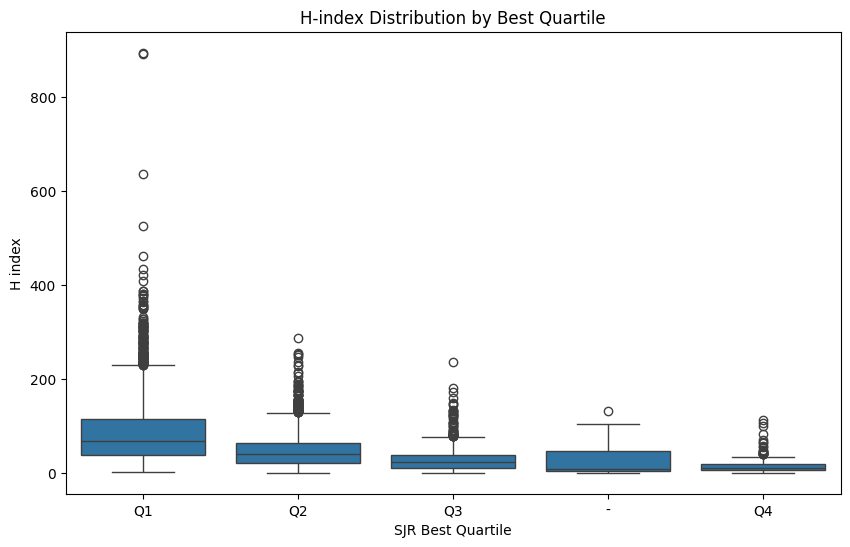

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the full path to your file in Google Drive
file_path = '/content/drive/MyDrive/PhD/BGU/BigData/HW3/scimagojr 2023.csv'

df = pd.read_csv(file_path, delimiter=';')
print(df.head())

# Load the dataset (assuming the dataset is already loaded into 'df')
top_publishers = df['Publisher'].value_counts().head(10).index  # Getting the top publishers

# Filter for the top publishers and Best Quartile
df_top_publishers = df[df['Publisher'].isin(top_publishers)]
plt.figure(figsize=(10, 6))

# Create a boxplot of H-index distribution based on Best Quartile
sns.boxplot(data=df_top_publishers, x='SJR Best Quartile', y='H index')
plt.title('H-index Distribution by Best Quartile')
plt.show()


Index(['Rank', 'Sourceid', 'Title', 'Type', 'Issn', 'SJR', 'SJR Best Quartile',
       'H index', 'Total Docs. (2023)', 'Total Docs. (3years)', 'Total Refs.',
       'Total Cites (3years)', 'Citable Docs. (3years)',
       'Cites / Doc. (2years)', 'Ref. / Doc.', '%Female', 'Overton', 'SDG',
       'Country', 'Region', 'Publisher', 'Coverage', 'Categories', 'Areas'],
      dtype='object')


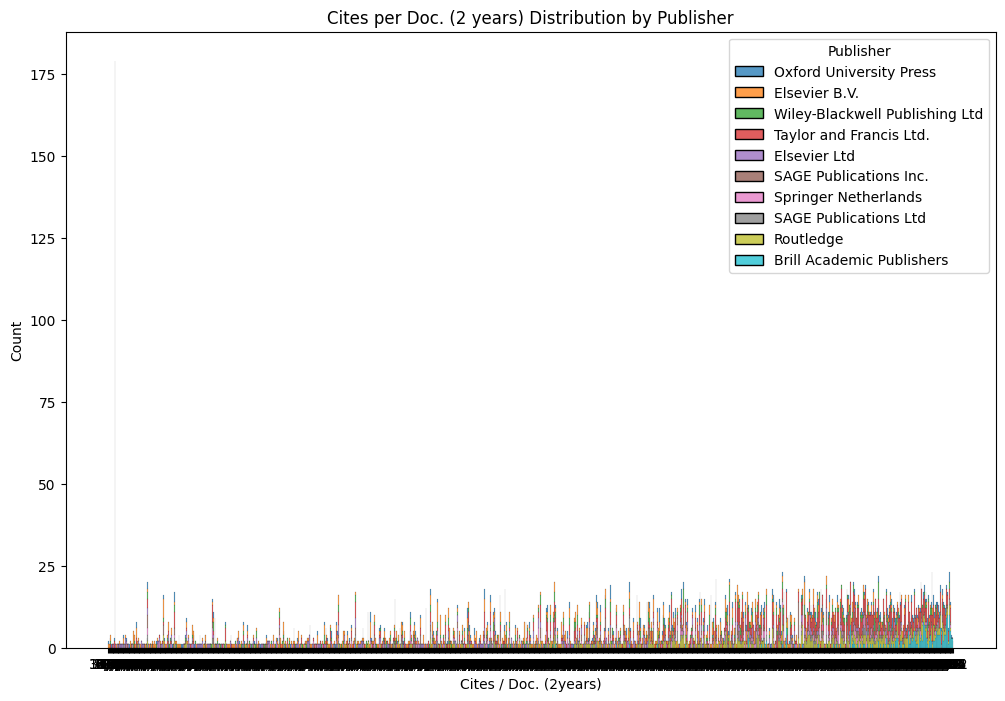

In [110]:
# Visualizing the distribution of 'Cites / Doc. (2 years)' for each publisher
plt.figure(figsize=(12, 8))

print(df_top_publishers.columns)

# Using a grid to visualize the histograms for each publisher
sns.histplot(data=df_top_publishers, x='Cites / Doc. (2years)', hue='Publisher', multiple='stack', bins=30)
plt.title('Cites per Doc. (2 years) Distribution by Publisher')
plt.show()
